In [1]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [2]:
! pip install -U accelerate
! pip install -U transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [3]:
!pip install Datasets

In [4]:
import numpy as np
import pandas as pd

from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data_hf = load_dataset("okite97/news-data")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
data_hf

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 4686
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 828
    })
})

In [8]:
data_hf["train"][0]

{'Title': 'Uefa Opens Proceedings against Barcelona, Juventus and Real Madrid Over European Super League Plan',
 'Excerpt': 'Uefa has opened disciplinary proceedings against Barcelona, Juventus and Real Madrid over their involvement in the proposed European Super League.',
 'Category': 'sports'}

In [9]:
unique_c = set(data_hf["train"]["Category"])
unique_c

{'business', 'entertainment', 'health', 'politics', 'sports', 'tech'}

In [10]:
df = data_hf["train"].to_pandas()

In [11]:
df.isna().value_counts()
df.dropna()


,Title,Excerpt,Category
0,"Uefa Opens Proceedings against Barcelona, Juve...",Uefa has opened disciplinary proceedings again...,sports
1,Amazon Blames Inflation as It Increases Cost o...,The increases are steeper than the 17 percent ...,business
2,Nigeria’s Parliament Passes Amended Electoral ...,Nigeria's Senate on Tuesday passed the harmoni...,politics
3,Nigeria: Lagos Governor Tests Positive for Cov...,"The Lagos State Governor, Mr. Babajide Sanwo-O...",health
4,South Africa Calls For Calm as Electoral Refor...,South Africa has raised concerns about the det...,politics
...,...,...,...
4681,Uganda Drops Charges Against Nigerian Singers ...,Nigerian singers Omah Lay and Tems are set to ...,entertainment
4682,NNPC Cuts Directors’ Fees by 60.2%,The Nigerian National Petroleum Corporation (N...,business
4683,Nigeria’s External Reserves Hit $37bn with $3....,Nigeria’s foreign reserves will get a timely b...,business
4684,Transcorp Hilton Wins Africa’s Leading Busines...,Transcorp Hilton Abuja has been honoured with ...,business


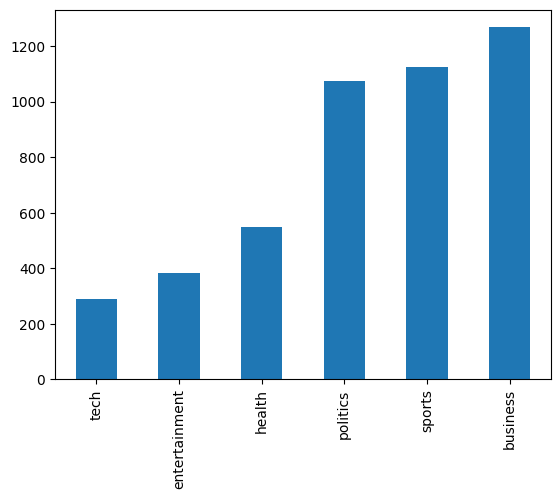

In [12]:
ax = df.Category.value_counts().sort_values().plot(x="Category",y="Count",kind="bar")


In [13]:
labels,unique = df['Category'].factorize(sort=True)


In [14]:
unique

Index(['business', 'entertainment', 'health', 'politics', 'sports', 'tech'], dtype='object')

In [15]:
label2id = {label:id for id,label in enumerate(unique)}
id2label = {id:label for id,label in enumerate(unique)}

label2id

{'business': 0,
 'entertainment': 1,
 'health': 2,
 'politics': 3,
 'sports': 4,
 'tech': 5}

In [16]:
df['labels'] = labels

In [17]:
df.head()

,Title,Excerpt,Category,labels
0,"Uefa Opens Proceedings against Barcelona, Juve...",Uefa has opened disciplinary proceedings again...,sports,4
1,Amazon Blames Inflation as It Increases Cost o...,The increases are steeper than the 17 percent ...,business,0
2,Nigeria’s Parliament Passes Amended Electoral ...,Nigeria's Senate on Tuesday passed the harmoni...,politics,3
3,Nigeria: Lagos Governor Tests Positive for Cov...,"The Lagos State Governor, Mr. Babajide Sanwo-O...",health,2
4,South Africa Calls For Calm as Electoral Refor...,South Africa has raised concerns about the det...,politics,3


In [18]:
df['Title'] = df['Title'].astype(str)

In [19]:
max_length = df['Title'].apply(len).max()

In [20]:
max_length

144

#Tokeinzation

In [21]:
ds = Dataset.from_pandas(df)

In [22]:
ds

Dataset({
    features: ['Title', 'Excerpt', 'Category', 'labels'],
    num_rows: 4686
})

In [23]:
model_nm = 'microsoft/deberta-v3-small'

In [24]:
tokz = AutoTokenizer.from_pretrained(model_nm)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [25]:
def tok_func(x): return tokz(x["Title"])

In [26]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/4686 [00:00<?, ? examples/s]

In [27]:
row = tok_ds[0]

In [ ]:
row['Title'], row['input_ids'] #Tiltes tokenized

In [29]:
tokz.vocab['▁Super']

2479

In [30]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3514
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1172
    })
})

In [31]:
dds['test']['labels'][0]

5

# Test Set Pre-Process

In [32]:
eval_df = data_hf["test"].to_pandas()

In [33]:
eval_df['labels'] = eval_df['Category'].map({'business':0, 'entertainment':1, 'health':2, 'politics':3, 'sports':4, 'tech':5})

In [34]:
eval_df.head()

,Title,Excerpt,Category,labels
0,Nigeria: Cross River Governor Ayade Dumps PDP ...,"Cross River State Governor, Ben Ayade has defe...",politics,3
1,Electoral Bill: Nigeria Senate Mobilises to Ov...,Nigerians have not heard the last of President...,politics,3
2,Nigeria: Central Bank Increases Forex Allocati...,The Central Bank of Nigeria (CBN) on Sunday an...,business,0
3,Nigeria to Set Up Fund to Cover 83m Poor Citiz...,President Muhammadu Buhari has signed into law...,health,2
4,World Bank Revises Sub-Saharan Africa’s Growth...,The World Bank has revised its growth forecast...,business,0


In [ ]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

In [ ]:
eval_ds

#Metrics


In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [38]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#Training

In [39]:
bs = 16
epochs = 3
lr = 8e-5 #keep it greater than 5e-4(orignal model's lr)

In [47]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',fp16 = True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none',logging_steps = 220)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm,num_labels=6,id2label=id2label, label2id=label2id)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz,compute_metrics = compute_metrics)

In [ ]:
model

In [50]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.873100,0.409401,0.870307
2,0.375400,0.390757,0.894198
3,0.237700,0.445188,0.894198


In [51]:
trainer.evaluate()

{'eval_loss': 0.4451884925365448,
 'eval_accuracy': 0.89419795221843,
 'eval_runtime': 0.7471,
 'eval_samples_per_second': 1568.817,
 'eval_steps_per_second': 49.528,
 'epoch': 3.0}

In [52]:
preds = trainer.predict(eval_ds)
preds.metrics

{'test_loss': 0.4111642837524414,
 'test_accuracy': 0.9057971014492754,
 'test_runtime': 0.6937,
 'test_samples_per_second': 1193.642,
 'test_steps_per_second': 37.482}

#Save Model

In [53]:
trainer.save_model("save")

#Inference

In [54]:
title_text = "Michael Caine confirms retirement from acting after The Great Escaper" #taken from bbc news
tok_text = tokz(title_text,return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in tok_text.items()}

outputs = model(**encoding)

In [55]:
logits = outputs.logits
logits

tensor([[-0.2861,  4.7773, -1.2246, -0.3237, -1.4434, -1.2236]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

In [56]:
predicted_class_id = int(torch.argmax(logits, axis=-1)[0])
c = model.config.id2label[predicted_class_id]
print(f"The given title text is categorized into {c} category.")

The given title text is categorized into entertainment category.
